# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [25]:
#%%pycodestyle
from sklearn.metrics.pairwise import euclidean_distances as ED


class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.distance = ED
        if self.init == 'random':
            self.init_centroids = self.random_init
        elif self.init == 'k-means':
            self.init_centroids = self.kmeans_init

    def random_init(self, X):
        return X[np.random.choice(X.shape[0],
                                  size=self.k, replace=False)]

    def kmeans_init(self, X):
        centroids = np.empty((self.k, X.shape[1]))
        # первый центроид выбирается произвольно
        random_num = np.random.randint(0, X.shape[0])
        centroids[0, :] = X[random_num, :]

        for cur_num in range(1, self.k):
            centroids = np.nan_to_num(centroids)
            distances = self.distance(X, centroids).min(axis=0)
            probs = distances / np.sum(distances)
            cumprobs = np.cumsum(probs)

            num = np.random.sample()
            ind = np.where(cumprobs >= num)[0][0]
            centroids[cur_num, :] = X[ind, :]
        return centroids

    def find_labels(self, X):
        self.centroids = np.nan_to_num(self.centroids)
        distances = self.distance(X, self.centroids)
        return np.argmin(distances, axis=1)

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = self.init_centroids(X)

        for _ in range(self.max_iter):
            self.labels = self.find_labels(X)
            new_centroids = np.empty((self.k, X.shape[1]))
            for cl_num in range(self.k):
                if np.any(self.labels == cl_num, axis=0):
                    new_centroids[cl_num] = X[self.labels == cl_num, :].\
                        mean(axis=0)
                else:
                    new_centroids[cl_num] = X[np.random.choice(X.shape[0])]

            if np.all(new_centroids == self.centroids):
                break
            self.centroids = new_centroids
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        Возвращает метку ближайшего кластера для каждого объекта
        """

        return self.find_labels(X)


class MiniBatchKMeans(MyKmeans):

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=100):

        self.batch_size = batch_size
        super().__init__(k, metric, max_iter, random_state, init)

    def get_batch(self, X):
        if self.batch_size > X.shape[0]:
            return X
        idx = np.random.choice(X.shape[0], size=self.batch_size)
        return X[idx]

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = self.init_centroids(X)
        per_centr_counts = np.zeros(self.k)

        for _ in range(self.max_iter):
            X_batch = self.get_batch(X)
            self.labels = self.find_labels(X_batch)
            new_centroids = np.empty((self.k, X.shape[1]))
            for i in range(X_batch.shape[0]):
                cl_num = self.labels[i]
                per_centr_counts[cl_num] += 1
                w = 1 / per_centr_counts[cl_num]
                new_centroids[cl_num] = (1 - w) * new_centroids[cl_num] +\
                    w * X_batch[i]
            if np.all(new_centroids == self.centroids):
                break
            self.centroids = np.copy(new_centroids)

        self.labels = self.find_labels(X)
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [38]:
from sklearn.datasets import make_blobs

In [39]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

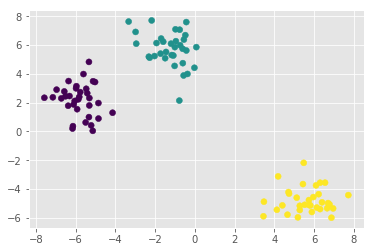

In [40]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

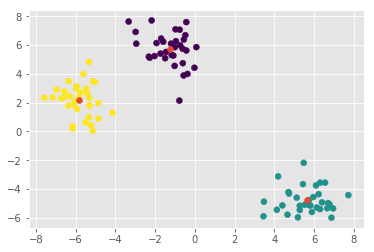

In [41]:
## Работоспособность MyKmeans
clst = MyKmeans(k=3)
clst.fit(X)
y_pred = clst.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(clst.centroids[:, 0], clst.centroids[:, 1])

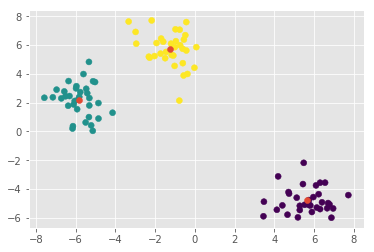

In [42]:
## Работоспособность MyKmeans++
clst = MyKmeans(k=3, init='k-means')
clst.fit(X)
y_pred = clst.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(clst.centroids[:, 0], clst.centroids[:, 1])

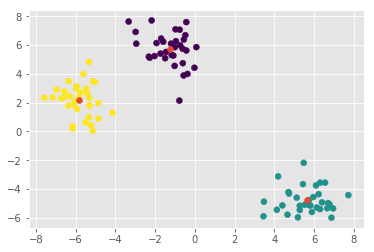

In [43]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
clst = MiniBatchKMeans(k=3)
clst.fit(X)
y_pred = clst.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(clst.centroids[:, 0], clst.centroids[:, 1])

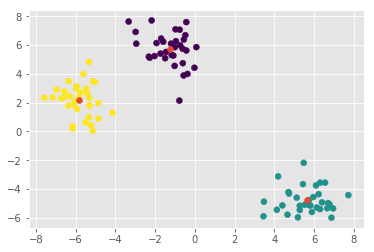

In [44]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
clst = MiniBatchKMeans(k=3, init='k-means')
clst.fit(X)
y_pred = clst.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(clst.centroids[:, 0], clst.centroids[:, 1])

In [45]:
## Время выполнения алгоритма Kmeans из sklearn
from sklearn.cluster import KMeans

sk_kmeans = KMeans(n_clusters=3, init='random', max_iter=1000,
                   precompute_distances=False, n_init=1, tol=0)

%time
sk_kmeans.fit(X)
pred = sk_kmeans.predict(X)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.1 µs


In [46]:
## Время выполнения алгоритма MyKmeans
kmeans = MyKmeans(k=3)

%time
kmeans.fit(X)
pred = kmeans.predict(X)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.9 µs


In [47]:
## Время выполнения алгоритма MyKmeans++
kmeans = MyKmeans(k=3, init='k-means')

%time
kmeans.fit(X)
pred = kmeans.predict(X)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 12.9 µs


In [48]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
kmeans = MiniBatchKMeans(k=3)

%time
kmeans.fit(X)
pred = kmeans.predict(X)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


In [49]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
kmeans = MiniBatchKMeans(k=3, init='k-means')

%time
kmeans.fit(X)
pred = kmeans.predict(X)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs


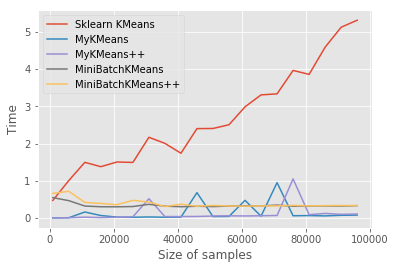

In [15]:
import time
from sklearn.cluster import KMeans

sizes = list(range(1000, 100001, 5000))
clsts = [
    [
        KMeans(n_clusters=3, init='random', max_iter=1000,
               precompute_distances=False, n_init=1, tol=0),
        'Sklearn KMeans'
    ],
    [
        MyKmeans(k=3),
        'MyKMeans'
    ],
    [
        MyKmeans(k=3, init='k-means'),
        'MyKMeans++'
    ],
    [
        MiniBatchKMeans(k=3, batch_size=10),
        'MiniBatchKMeans'
    ],
    [
         MiniBatchKMeans(k=3, init='k-means', batch_size=10),
        'MiniBatchKMeans++'
    ]  
]

results = np.empty((5, len(sizes)))

for i, size in enumerate(sizes):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    for j, clst in enumerate(clsts):
        tau = time.time()
        clst[0].fit(X)
        results[j][i] = time.time() - tau

for i, clst in enumerate(clsts):
    plt.plot(sizes, results[i], label=clst[1])

plt.xlabel('Size of samples')
plt.ylabel('Time')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [16]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [17]:
df_sns = df_sns[df_sns.columns[4:]]
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [18]:
X = (df_sns - df_sns.mean()) / df_sns.std()
print(X.shape)
X.head()

(30000, 36)


,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


In [19]:
tags = X.columns
tags

Index(['basketball', 'football', 'soccer', 'softball', 'volleyball',
       'swimming', 'cheerleading', 'baseball', 'tennis', 'sports', 'cute',
       'sex', 'sexy', 'hot', 'kissed', 'dance', 'band', 'marching', 'music',
       'rock', 'god', 'church', 'jesus', 'bible', 'hair', 'dress', 'blonde',
       'mall', 'shopping', 'clothes', 'hollister', 'abercrombie', 'die',
       'death', 'drunk', 'drugs'],
      dtype='object')

In [20]:
## MyKMeans
clst = MyKmeans(k=9)

%time
clst.fit(X.values)
for i, centroid in enumerate(clst.centroids):
    print('clst:', i, ' count:', clst.labels[clst.labels == i].size, end=' ')
    print('tags:', tags[np.argsort(centroid)[-5:]].values)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
clst: 0  count: 856 tags: ['clothes' 'mall' 'shopping' 'abercrombie' 'hollister']
clst: 1  count: 760 tags: ['god' 'rock' 'music' 'band' 'marching']
clst: 2  count: 200 tags: ['music' 'rock' 'hair' 'sex' 'kissed']
clst: 3  count: 18573 tags: ['bible' 'jesus' 'soccer' 'tennis' 'blonde']
clst: 4  count: 2340 tags: ['church' 'jesus' 'god' 'bible' 'death']
clst: 5  count: 2146 tags: ['sports' 'football' 'baseball' 'softball' 'basketball']
clst: 6  count: 1060 tags: ['die' 'hair' 'kissed' 'drunk' 'drugs']
clst: 7  count: 492 tags: ['soccer' 'clothes' 'music' 'shopping' 'swimming']
clst: 8  count: 3573 tags: ['dance' 'dress' 'mall' 'cute' 'shopping']


* 0 -- девушки
* 1 -- увлекающиеся рок-музыкой
* 2 -- скорее, девушки, увлекающиеся рок-музыкой
* 3 -- плохо интерпретируется, слишком обширен
* 4 -- религиозные люди
* 5 -- увлекающиеся спортом
* 6 -- впадающие в крайности
* 7 -- девушки, увлекающиеся спортом
* 8 -- девушки

In [21]:
## MyKMeans++
clst = MyKmeans(k=9, init='k-means')

%time
clst.fit(X.values)
for i, centroid in enumerate(clst.centroids):
    print('clst:', i, ' count:', clst.labels[clst.labels == i].size, end=' ')
    print('tags:', tags[np.argsort(centroid)[-5:]].values)

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 11 µs
clst: 0  count: 3974 tags: ['dance' 'hot' 'mall' 'cute' 'shopping']
clst: 1  count: 891 tags: ['drunk' 'sex' 'hair' 'drugs' 'kissed']
clst: 2  count: 569 tags: ['football' 'rock' 'music' 'band' 'marching']
clst: 3  count: 681 tags: ['basketball' 'football' 'shopping' 'sports' 'soccer']
clst: 4  count: 18914 tags: ['bible' 'death' 'jesus' 'tennis' 'blonde']
clst: 5  count: 2012 tags: ['football' 'volleyball' 'baseball' 'softball' 'basketball']
clst: 6  count: 840 tags: ['clothes' 'mall' 'shopping' 'abercrombie' 'hollister']
clst: 7  count: 1656 tags: ['hair' 'cute' 'shopping' 'dance' 'dress']
clst: 8  count: 463 tags: ['death' 'church' 'god' 'jesus' 'bible']


* 0 -- девушки
* 1 -- вероятно, завсегдатаи баров
* 2 -- увлекающиеся рок музыкой и спортом
* 3 -- увлекающиеся спортом
* 4 -- плохо интерпретируется, слишком обширен
* 5 -- увлекающиеся спортом
* 6 -- девушки
* 7 -- девушки
* 8 -- религиозные люди

In [35]:
## MyKMeans с MiniBatchMyKMeans
clst = MiniBatchKMeans(k=9, batch_size=10)

%time
clst.fit(X.values)
for i, centroid in enumerate(clst.centroids):
    print('clst:', i, ' count:', clst.labels[clst.labels == i].size, end=' ')
    print('tags:', tags[np.argsort(centroid)[-5:]].values)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
clst: 0  count: 251 tags: ['sexy' 'swimming' 'abercrombie' 'baseball' 'death']
clst: 1  count: 377 tags: ['cute' 'shopping' 'dance' 'sexy' 'drugs']
clst: 2  count: 969 tags: ['music' 'clothes' 'death' 'shopping' 'abercrombie']
clst: 3  count: 513 tags: ['music' 'basketball' 'volleyball' 'tennis' 'sports']
clst: 4  count: 73 tags: ['music' 'hair' 'drugs' 'sex' 'sports']
clst: 5  count: 32 tags: ['abercrombie' 'softball' 'football' 'clothes' 'cheerleading']
clst: 6  count: 2172 tags: ['marching' 'bible' 'blonde' 'hair' 'rock']
clst: 7  count: 23725 tags: ['cheerleading' 'drunk' 'dress' 'marching' 'softball']
clst: 8  count: 1888 tags: ['marching' 'bible' 'blonde' 'rock' 'music']


* 0 -- девушки
* 1 -- девушки
* 2 -- тоже девушки
* 3 -- увлекающиеся спортом
* 4 -- ничего примечательного, если drugs понимать, как лекарства
* 5 -- снова девушки
* 6 -- плохо интерпретируется
* 7 -- увлекающиеся спортом
* 8 -- религиозные люди

In [36]:
## MyKMeans++ с MiniBatchMyKMeans
clst = MiniBatchKMeans(k=9, init='k-means', batch_size=10)

%time
clst.fit(X.values)
for i, centroid in enumerate(clst.centroids):
    print('clst:', i, ' count:', clst.labels[clst.labels == i].size, end=' ')
    print('tags:', tags[np.argsort(centroid)[-5:]].values)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
clst: 0  count: 484 tags: ['god' 'cute' 'dress' 'hot' 'drunk']
clst: 1  count: 357 tags: ['blonde' 'football' 'sexy' 'shopping' 'dance']
clst: 2  count: 18177 tags: ['tennis' 'marching' 'bible' 'blonde' 'god']
clst: 3  count: 332 tags: ['god' 'cute' 'basketball' 'sexy' 'band']
clst: 4  count: 1608 tags: ['shopping' 'rock' 'dance' 'swimming' 'hot']
clst: 5  count: 2071 tags: ['music' 'shopping' 'softball' 'die' 'dance']
clst: 6  count: 1180 tags: ['shopping' 'music' 'jesus' 'clothes' 'basketball']
clst: 7  count: 2917 tags: ['bible' 'blonde' 'music' 'shopping' 'clothes']
clst: 8  count: 2874 tags: ['drugs' 'marching' 'bible' 'blonde' 'dance']


* 0 -- девушки
* 1 -- девушки
* 2 -- плохо интерпретируется, слишком обширен
* 3 -- увлекающиеся спортом
* 4 -- плохо интерпретируется
* 5 -- увлекающиеся спортом
* 6 -- плохо интерпретируется
* 7 -- плохо интерпретируется
* 8 -- религиозные люди

## Вывод
КMeans и MiniBatch с KMeans работают быстрее всего.

По интерпретируемости лучше всего выходило с KMeans и KMeans++.

MiniBatch при больших batch-size склонен работать быстрее, но, вне зависимости от batch-size, почему-то чаще
склонен запихивать все в один кластер.

Хуже всего по интерпретируемсти работает MiniBatch с KMeans++.